## UM atmosphere data loading and plotting with Iris

In [15]:
import os
import os.path
import glob

import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt

In [16]:
TOP_LEVEL_DIRECTORY = "/gws/nopw/j04/eerie/public/data"
model_resolution = "N640-ORCA12" # also N216-ORCA025
suiteid = "u-cx993" # also u-cy021
variable = "sosabs" # conservative temperature at surface
table = "Oday"
DIR_STRUCTURE = "EERIE/EERIE/MOHC/HadGEM3-GC5-EERIE-{model_resolution}/eerie-piControl/r1i1p1f1/{table}/{variable}/gr1/v20230928"

In [17]:
def load_callback(cube, field, filename):
    """
    An Iris load callback function to delete a few metadata items that will
    prevent the files from being merged into a single cube.
    """
    attributes_to_remove = [
        "name",
        "timeStamp",
        "uuid",
        "history"
    ]
    for attr_name in attributes_to_remove:
        del(cube.attributes[attr_name])

In [18]:
dir_variable = DIR_STRUCTURE.format(model_resolution=model_resolution, variable=variable, table=table)
search = os.path.join(TOP_LEVEL_DIRECTORY, dir_variable, 
    variable+"_nemo_"+suiteid+"_1d_185[12]*_grid-025.nc")
print(search)
toscon_paths = sorted(glob.glob(search))
#print('toscon_paths ',toscon_paths)

/gws/nopw/j04/eerie/public/data/EERIE/EERIE/MOHC/HadGEM3-GC5-EERIE-N640-ORCA12/eerie-piControl/r1i1p1f1/Oday/sosabs/gr1/v20230928/sosabs_nemo_u-cx993_1d_185[12]*_grid-025.nc


In [19]:
#toscon_paths = [os.path.join(TOP_LEVEL_DIRECTORY, file_path) for file_path in toscon_files]
cubes = iris.load(toscon_paths, callback=load_callback)
toscon = cubes.concatenate_cube()

/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'area', referenced by netCDF variable 'sosabs'
  warnings.warn(
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'area', referenced by netCDF variable 'sosabs'
  warnings.warn(
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'area', referenced by netCDF variable 'sosabs'
  warnings.warn(
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'area', referenced by netCDF variable 'sosabs'
  warnings.warn(
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'area', referenced by netCDF variable 'sosabs'
  warnings.warn(
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF m

In [20]:
print(toscon)

sea surface absolute salinity / (1e-3) (time: 731; latitude: 721; longitude: 1440)
    Dimension coordinates:
        time                                x              -               -
        latitude                            -              x               -
        longitude                           -              -               x
    Cell methods:
        mean                           time (450 s)
    Attributes:
        Conventions                    'CF-1.6'
        NCO                            'netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net, Code = ...
        branch_method                  'fixed pre-industrial forcing at 1850 was applied for 240 years of spin-up,...
        description                    'ocean T grid variables'
        experiment                     'coupled pre-industrial control'
        experiment_id                  'eerie-piControl'
        grid                           'Regular 0.25x0.25'
        grid_label                     'gr

We have now loaded the muliple netCDF files into a single Iris cube. We can now do something interesting with this loaded data.

### Plotting time slices

Plot the first time point.

/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/netcdf.py:416: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  var = variable[keys]


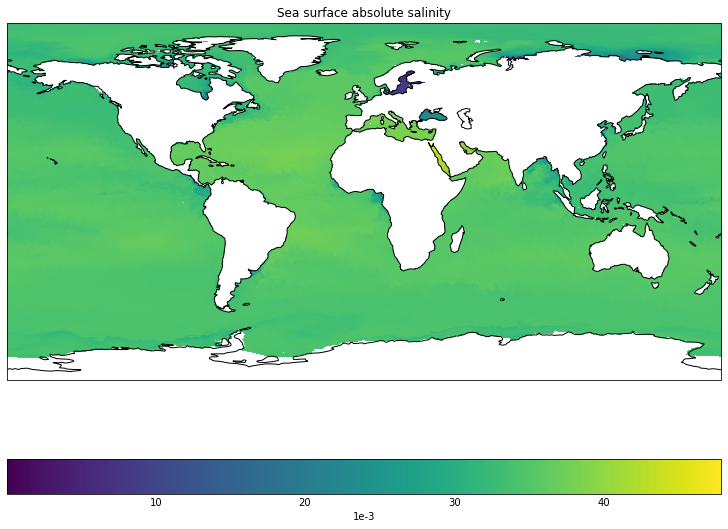

In [21]:
fig = plt.figure(figsize=[12.8, 9.6])
qplt.pcolormesh(toscon[0, ...])
plt.draw()
__ = plt.gca().coastlines()  # __ hides the return value in Notebooks

### Time mean

Calculate the area weighted global mean at each time slice and plot this series.

In [22]:
grid_areas = iris.analysis.cartography.area_weights(toscon)
# note this can run out of memory and cause server to restart if too many time points
global_mean = toscon.collapsed(
        ["latitude", "longitude"], iris.analysis.MEAN, weights=grid_areas
    )

/opt/jaspy/lib/python3.10/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [23]:
print(toscon.summary(shorten=True))
print(global_mean.summary(shorten=True))

sea surface absolute salinity / (1e-3) (time: 731; latitude: 721; longitude: 1440)
sea surface absolute salinity / (1e-3) (time: 731)


/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/netcdf.py:416: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  var = variable[keys]


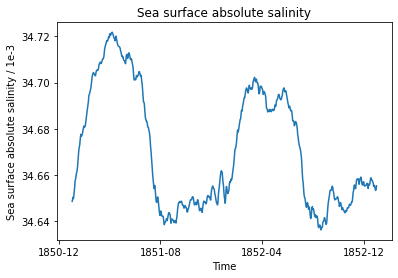

In [24]:
fig = plt.figure()
qplt.plot(global_mean)
plt.draw()